# FISH - Data interpretation - A Python interactive notebook to interpret FISH data

```
Author: Luis U. Aguilera
Contact Info: luis.aguilera@colostate.edu

Copyright (c) 2021 Munsky Group 
Colorado State University 
Licensed under BSD 3-Clause License.

```

## Importing libraries

In [1]:
import sys
import matplotlib.pyplot as plt 
from  matplotlib.ticker import FuncFormatter
import numpy as np 
import pandas as pd
import pathlib
import warnings
import glob
import seaborn as sns
import zipfile
import shutil
import scipy.stats as stats
import os
warnings.filterwarnings("ignore")

## Defining paths

In [2]:
# Defining directories
current_dir = pathlib.Path().absolute()
fa_dir = current_dir.parents[0].joinpath('src')
# Importing fish_analyses module
sys.path.append(str(fa_dir))
import fish_analyses as fa
# Local folder path
local_folder_path = pathlib.Path().absolute().joinpath('temp_zip_analyses')
#local_folder_path
# Path to credentials
desktop_path = pathlib.Path.home()/'Desktop'
# Connection to munsky-nas
path_to_config_file = desktop_path.joinpath('config.yml')
share_name = 'share'

# creating a folder to store all plots
destination_folder = pathlib.Path().absolute().joinpath('results', 'data_Huy_combinations_final_test')
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder) 

In [3]:
psf_z=350                # Theoretical size of the PSF emitted by a [rna] spot in the z plan, in nanometers
psf_yx=160               # Theoretical size of the PSF emitted by a [rna] spot in the yx plan, in nanometers
voxel_size_z=500         # Microscope conversion px to nanometers in the z axis.
voxel_size_yx=160        # Microscope conversion px to nanometers in the xy axis.
#scale = np.array ([ voxel_size_z/psf_z, voxel_size_yx/psf_yx, voxel_size_yx/psf_yx ])
list_timepoints = [0,18,300]
ts_distance=2


## List of folders to process

In [4]:
def Huy_data(mandatory_substring):
    list_dirs=(
    'smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_woStim',
    'smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_18minTPL_5uM' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_5hTPL_5uM' )
    list_labels = [ 'woSTM','18minTPL_5uM','5hTPL_5uM']
    plot_title_suffix= "MS2_CY5"
    mandatory_substring = mandatory_substring      #'nuc_71__cyto_0__psfz_350__psfyx_160__ts_550_400'
    return list_dirs, list_labels, plot_title_suffix, mandatory_substring

----

# Running the codes

----

In [5]:
mandatory_substring = 'nuc_70__cyto_0__psfz_350__psfyx_160__ts_550_400'
int_0 = 550
int_1 = 400

## Connecting to NAS and extracting data

In [6]:
%%capture
# downloading data from NAS
list_dirs, list_labels, plot_title_suffix, mandatory_substring = Huy_data(mandatory_substring=mandatory_substring)
list_local_files = fa.Utilities().read_zipfiles_from_NAS(list_dirs,path_to_config_file,share_name, mandatory_substring, local_folder_path)
list_local_folders = fa.Utilities().unzip_local_folders(list_local_files,local_folder_path)
list_dataframes = fa.Utilities().extracting_data_for_each_df_in_directory(  list_local_folders=list_local_folders, current_dir=current_dir,minimum_spots_cluster=2)[6]

In [7]:
# Iterating for each time point (experimental condition)
# selecting one condition woSTM
selected_dataframe = list_dataframes[0] # This selects the condidition woSTM
df_spots_classification, df_coordinates_colocalized_spots, df_coordinates_0_only_spots, df_coordinates_1_only_spots  = fa.ColocalizationDistance(df = selected_dataframe,
                                                                                                                                                    show_plots = False, 
                                                                                                                                                    time_point = 0, 
                                                                                                                                                    threshold_intensity_0 = int_0,
                                                                                                                                                    threshold_intensity_1 = int_1,
                                                                                                                                                    report_codetected_spots_in_both_channels = False,
                                                                                                                                                    threshold_distance=ts_distance).extract_spot_classification_from_df()


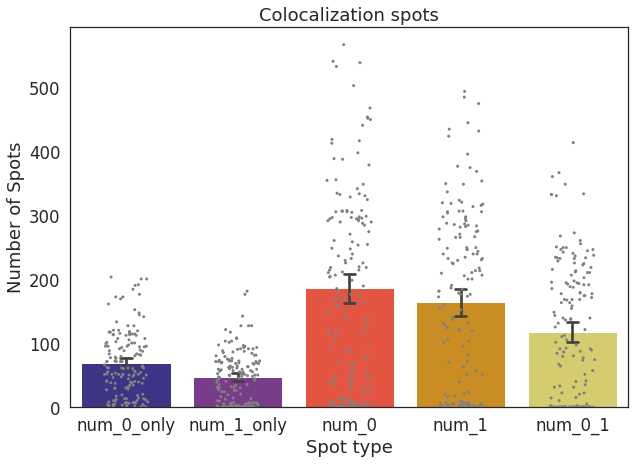

In [11]:
df_melted = pd.melt(df_spots_classification, id_vars = ['cell_id'], value_vars = ['num_0_only','num_1_only','num_0','num_1','num_0_1'])
plt.figure(figsize=(10,7))
sns.set_style("white")
color_palete = 'CMRmap'
p_bar = sns.barplot( x = 'variable',y = 'value',data = df_melted,capsize = 0.1,palette=color_palete)
p = sns.stripplot(data=df_melted, x = 'variable',y = 'value',size=3, color='0.5', jitter=0.2)
# Show the plot
p_bar.set_xlabel('Spot type')
p_bar.set_ylabel('Number of Spots')
p_bar.set_title('Colocalization spots')
sns.set(font_scale = 1.5)
plt.show()